In [1]:
library('SGL')
library('grpregOverlap')
library('MASS')
library('glmnet')

Loading required package: Matrix
Loading required package: grpreg

Attaching package: ‘MASS’

The following object is masked from ‘package:grpregOverlap’:

    select

The following object is masked from ‘package:grpreg’:

    select

Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
df <- read.csv('/homes/gws/psturm/simulatedData/regressionData/df0.csv', header=TRUE)
df = as.data.frame(df)
numPheno <- 100
numGenes <- 1000
numSamples <- 100

In [3]:
head(df)

X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,coeff90,coeff91,coeff92,coeff93,coeff94,coeff95,coeff96,coeff97,coeff98,coeff99
-0.89289816,-0.7838450,-44.821172,0.56758256,1.2301576,-11.49766,1.4829676,-0.3546174,0.06139415,0.4679509,⋯,0,0,0,0,0,0,0,0,0,0
-0.21115331,0.3457023,3.209153,0.01279545,-1.3035371,27.23761,-0.6892684,0.5408580,-0.88648320,0.5758426,⋯,0,0,0,0,0,0,0,0,0,0
1.58723300,-1.2708441,28.677197,-0.62189750,0.7203938,19.69739,1.2466461,1.1291675,-1.01628380,2.5097459,⋯,0,0,0,0,0,0,0,0,0,0
-0.13268570,0.6958898,26.422647,0.49544448,-0.3562564,-17.63835,-1.7797455,0.7861921,0.11880796,-1.1745348,⋯,0,0,0,0,0,0,0,0,0,0
-0.03722321,0.5664295,-26.109134,-0.66025335,0.3149487,-21.67632,1.2361558,1.6355056,-1.63663864,-0.7560604,⋯,0,0,0,0,0,0,0,0,0,0
-0.03999930,1.5565694,-98.613098,-1.02054539,-2.2917692,15.63123,-1.0374151,0.1409125,-1.28236363,-1.2262085,⋯,0,0,0,0,0,0,0,0,0,0


In [4]:
df_t = as.data.frame(t(df))
colnames(df_t) = c(paste('p', sep='', 1:numPheno), paste('g', sep='', 1:numGenes))
data_mat = df_t[1:numSamples, ]

In [5]:
group_index <- unlist(df['gene_group'][-(1:numPheno), ])

In [6]:
y <- data_mat$p1
x <- data.matrix(data_mat[, paste('g', sep='', 1:numGenes)])

In [7]:
alphalist <- seq(0,1,by=0.1)
elasticnet <- lapply(alphalist, function(a){
  cv.glmnet(x, y, alpha=a)
})

In [8]:
elasticnet_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(elasticnet, function(o) {o$lambda.min}))), 
                            'cvm' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvm[o$lambda == o$lambda.min]}))),
                            'cvsd' = as.numeric(unlist(lapply(elasticnet, function(o) {
                                o$cvsd[o$lambda == o$lambda.min]}))),
                            'alpha' = alphalist)

In [9]:
elasticnet_df

lambda.min,cvm,cvsd,alpha
220.1010882,21.526094,7.8000518,0.0
3.3453408,1.005868,0.2694737,0.1
1.7523159,1.057591,0.3886372,0.2
1.1151136,1.075737,0.3581548,0.3
0.8761579,1.100116,0.2815920,0.4
0.6690682,1.213191,0.3884404,0.5
0.5322150,1.015446,0.1982162,0.6
0.4779058,1.159644,0.3397460,0.7
0.3991612,1.382720,0.4004203,0.8
0.3548100,1.215339,0.2714335,0.9


In [10]:
typeof(elasticnet_df$alpha)

[1] "double"

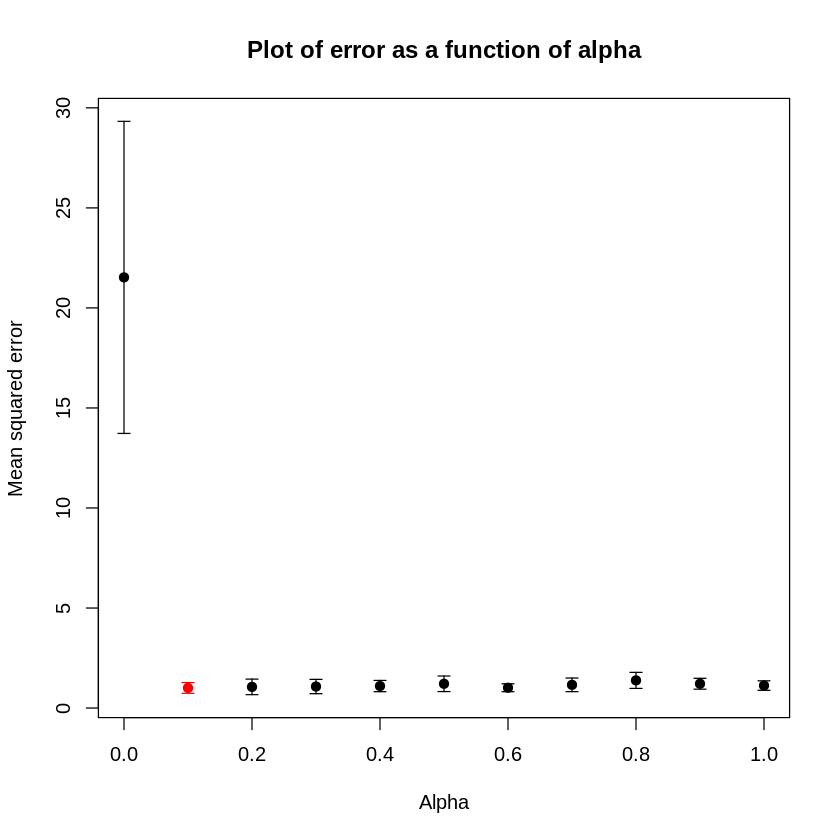

In [11]:
best_alpha <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$alpha
best_lambda <- elasticnet_df[elasticnet_df$cvm == min(elasticnet_df$cvm),]$lambda.min
plot(elasticnet_df$alpha, elasticnet_df$cvm,
     ylim=range(c(elasticnet_df$cvm-elasticnet_df$cvsd, elasticnet_df$cvm+elasticnet_df$cvsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black")
    )
arrows(elasticnet_df$alpha, elasticnet_df$cvm-elasticnet_df$cvsd, 
       elasticnet_df$alpha, elasticnet_df$cvm+elasticnet_df$cvsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(elasticnet_df$alpha==best_alpha, "red", "black"))

In [12]:
cat(sprintf('Elastic net: best alpha = %f, best lambda = %f', best_alpha, best_lambda))

Elastic net: best alpha = 0.100000, best lambda = 3.345341

In [ ]:
alphalist <- seq(0,1,by=0.1)
sparse_gl <- lapply(alphalist, function(a){
  cvSGL(data=list(x=x, y=y), index=group_index, min.frac=0.01, type="linear", alpha=a)
})

In [23]:
names(sparse_gl[[6]])

[1] "fit"     "lldiff"  "lambdas" "type"    "llSD"

In [ ]:
sparse_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                            o$lambdas[o$lldiff == min(o$lldiff)]}))), 
                            'nll' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                min(o$lldiff)}))),
                            'nllsd' = as.numeric(unlist(lapply(sparse_gl, function(o) {
                                o$llSD[o$lldiff == min(o$lldiff)]}))),
                            'alpha' = alphalist)
sparse_gl_df

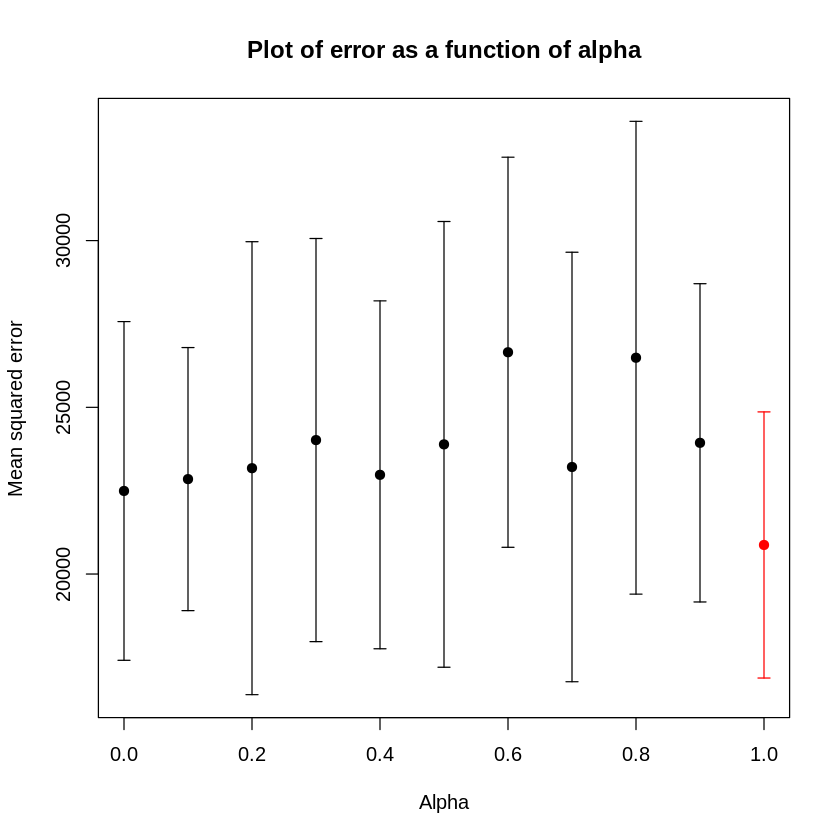

In [24]:
best_alpha_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$alpha
best_lambda_sgl <- sparse_gl_df[sparse_gl_df$nll == min(sparse_gl_df$nll),]$lambda.min
plot(sparse_gl_df$alpha, sparse_gl_df$nll,
     ylim=range(c(sparse_gl_df$nll-sparse_gl_df$nllsd, sparse_gl_df$nll+sparse_gl_df$nllsd)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black")
    )
arrows(sparse_gl_df$alpha, sparse_gl_df$nll-sparse_gl_df$nllsd,
       sparse_gl_df$alpha, sparse_gl_df$nll+sparse_gl_df$nllsd, 
       length=0.05, angle=90, code=3,
       col=ifelse(sparse_gl_df$alpha==best_alpha_sgl, "red", "black"))

In [25]:
cat(sprintf('Sparse Group Lasso: best alpha = %f, best lambda = %f', best_alpha_sgl, best_lambda_sgl))

Sparse Group Lasso: best alpha = 1.000000, best lambda = 1.235071

In [ ]:
group_df <- lapply(unique(group_index), function(o, gi) { 
    paste('g', which(gi == 0), sep='')
}, 
group_index)

In [ ]:
alphalist <- seq(0.1,1,by=0.1)
overlap_gl <- lapply(alphalist, function(a){
  cv.grpregOverlap(x, y, group_df, penalty="grLasso", alpha=a)
})

In [26]:
overlap_gl_df <- data.frame('lambda.min' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                            o$lambda[o$cve == min(o$cve)]}))), 
                            'cve' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                min(o$cve)}))),
                            'cvse' = as.numeric(unlist(lapply(overlap_gl, function(o) {
                                o$cvse[o$cve == min(o$cve)]}))),
                            'alpha' = alphalist)
overlap_gl_df

lambda.min,cve,cvse,alpha
1.4407057,84.43953,22.16676,0.1
0.8903019,68.01603,15.71039,0.2
0.5758433,78.30637,14.40924,0.3
0.3712419,74.33329,12.68770,0.4
0.3252162,74.76289,13.41651,0.5
0.3667821,65.73422,13.21956,0.6
0.2253733,84.86361,17.16352,0.7
0.1913237,67.39704,12.26679,0.8
0.2520337,62.64463,11.45363,0.9
0.2268303,66.26376,11.93144,1.0


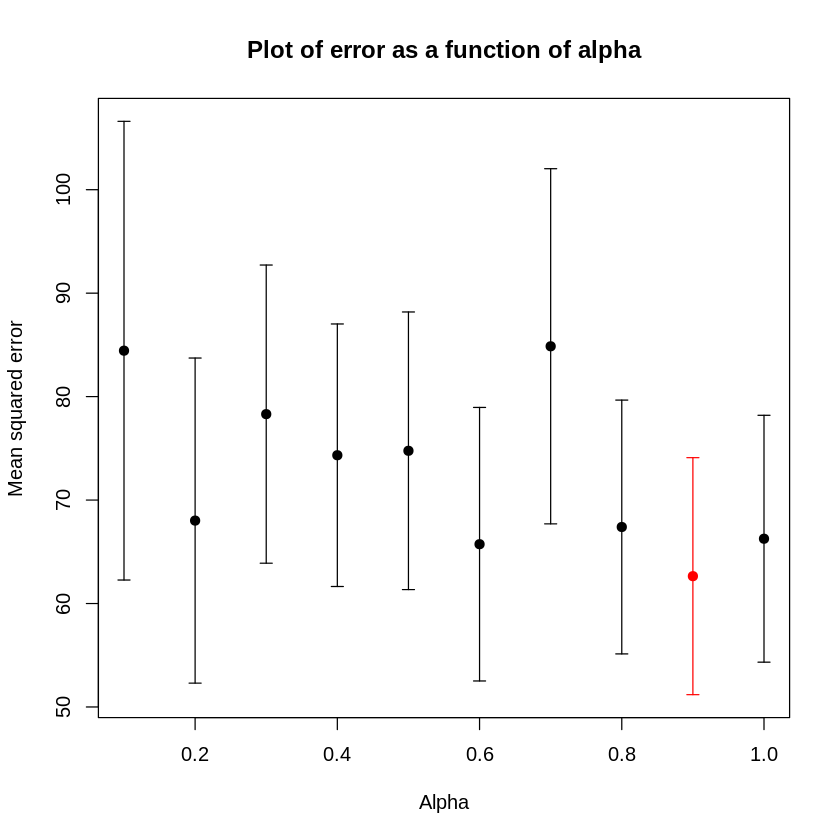

In [27]:
best_alpha_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$alpha
best_lambda_ovl <- overlap_gl_df[overlap_gl_df$cve == min(overlap_gl_df$cve),]$lambda.min
plot(overlap_gl_df$alpha, overlap_gl_df$cve,
     ylim=range(c(overlap_gl_df$cve-overlap_gl_df$cvse, overlap_gl_df$cve+overlap_gl_df$cvse)),
     pch=19, xlab="Alpha", ylab="Mean squared error",
     main="Plot of error as a function of alpha",
     col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black")
    )
arrows(overlap_gl_df$alpha, overlap_gl_df$cve-overlap_gl_df$cvse, 
       overlap_gl_df$alpha, overlap_gl_df$cve+overlap_gl_df$cvse, 
       length=0.05, angle=90, code=3,
       col=ifelse(overlap_gl_df$alpha==best_alpha_ovl, "red", "black"))

In [28]:
cat(sprintf('Overlapping Group Lasso: best alpha = %f, best lambda = %f', best_alpha_ovl, best_lambda_ovl))

Overlapping Group Lasso: best alpha = 0.900000, best lambda = 0.252034